### Relevance Vector Machine

Метод релевантных векторов -- линейная регрессия под амфетамином с дисперсиями и байесовскими методами.

#### TODO:
  * Добавить формул сюда
  * Добавить объяснение минимизации риска(и сравнение с SVM/LR) => автоматический выбор сложности модели
  * из 4 bias/variance сравнений оставить только 2(+добавить сравнение с классической LR).
  * ???


http://www.machinelearning.ru/wiki/index.php?title=RVM

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [205]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

### Генерируем выборку

In [206]:
from skbayes.rvm_ard_models import RVR
N = 5000

In [262]:
x = np.linspace(-5, 5, N)
X = np.vstack([x, np.cos(x)]).T
Y = 10 * np.sinc(X[:, 0]) + np.random.randn(N)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

Y_test = Y_test[np.argsort(X_test[:, 0])]
X_test = X_test[np.argsort(X_test[:, 0])]

In [263]:
rvm = RVR(kernel='linear')
rvm.fit(X_train, Y_train)

RVR(coef0=1, copy_X=True, degree=3, fit_intercept=True, gamma=None,
  kernel='linear', kernel_params=None, n_iter=300, tol=0.001,
  verbose=False)

In [264]:
rvm = RVR(kernel='poly', degree=3)
rvm.fit(X_train, Y_train)

RVR(coef0=1, copy_X=True, degree=3, fit_intercept=True, gamma=None,
  kernel='poly', kernel_params=None, n_iter=300, tol=0.001, verbose=False)

In [265]:
Y_pred, Y_pred_std = rvm.predict_dist(X_test)
mean_squared_error(Y_pred, Y_test)

1.1689620986252736

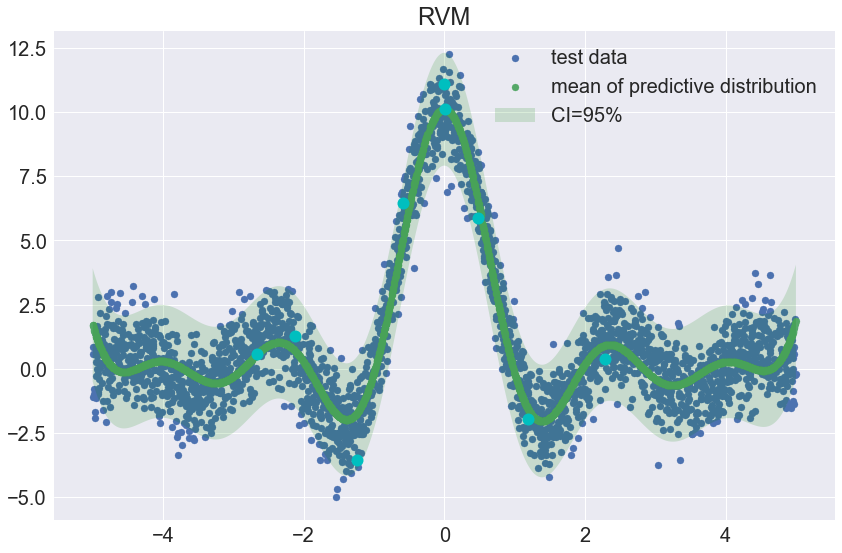

In [266]:
plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.plot(rvm.relevant_vectors_[:, 0], Y_train[rvm.active_], "co", markersize = 12)
plt.legend()
plt.title("RVM")
plt.show()

In [267]:
rvm.lambda_[rvm.active_]

array([2.08774145e-01, 1.85593327e-04, 1.06634882e-05, 1.15286707e-04,
       1.32337296e-05, 3.09415079e+06, 6.74479702e-03, 2.00273490e-02,
       5.51630526e-06])

In [268]:
rvm.sigma_

array([[ 4.78905851e+00, -4.36368031e-03,  4.33723335e-02,
         4.72991519e-03, -3.00588280e-02,  4.90088447e-07,
        -3.11350842e-04,  2.01564500e-04, -4.80262255e+00],
       [-4.36368031e-03,  1.16884452e+00, -4.56614550e+00,
         1.43898557e+00, -4.06714324e+00,  4.04449017e-07,
        -1.79941288e-01, -1.07127495e-01,  6.27570313e+00],
       [ 4.33723335e-02, -4.56614550e+00,  1.78791773e+01,
        -5.66692778e+00,  1.59845590e+01, -2.93869479e-06,
         7.09640718e-01,  4.17804140e-01, -2.46402232e+01],
       [ 4.72991519e-03,  1.43898557e+00, -5.66692778e+00,
         1.82292918e+00, -5.11572774e+00,  3.05642718e-06,
        -2.29105632e-01, -1.31136739e-01,  7.82480623e+00],
       [-3.00588280e-02, -4.06714324e+00,  1.59845590e+01,
        -5.11572774e+00,  1.43823449e+01, -5.72358982e-06,
         6.42110147e-01,  3.71170062e-01, -2.20226200e+01],
       [ 4.90088447e-07,  4.04449017e-07, -2.93869479e-06,
         3.05642718e-06, -5.72358982e-06,  3.228366

### Bias-Variance decomposition

$$\bar{y} = \frac{1}{N} \sum \hat{y}_i$$

$$bias^2=MSE(y, \bar{y})$$

$$variance=\frac{1}{N} \sum MSE(\hat{y}_i, \bar{y})$$

### Bias-Variance при увеличении признаковго представления

In [213]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from tqdm import tqdm

In [238]:
bias = []
variance = []
error = []
degrees = np.arange(1, 10)
resamples = 10

for degree in tqdm(degrees):
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    
    Y_preds = []
    for _ in range(resamples):
        X_train_resample, Y_train_resample = resample(X_train, Y_train)
        X_train_resample = pf.fit_transform(X_train_resample)
        X_test_pf = pf.transform(X_test)
        rvm = RVR(kernel='linear')
        rvm.fit(X_train_resample, Y_train_resample)
        Y_pred = rvm.predict(X_test_pf)
        Y_preds.append(Y_pred)
        
    Y_preds = np.array(Y_preds)
    bias.append(
        ((Y_preds.mean(axis=0) - Y_test)**2).mean()
    )
    variance.append(
        ((Y_preds - Y_preds.mean(axis=0))**2).mean(axis=1).mean()
    )
    error.append(
        ((Y_preds - Y_test)**2).mean(axis=1).mean()
    )
bias = np.array(bias)
variance = np.array(variance)
error = np.array(error)

100%|██████████| 9/9 [01:22<00:00,  8.94s/it]


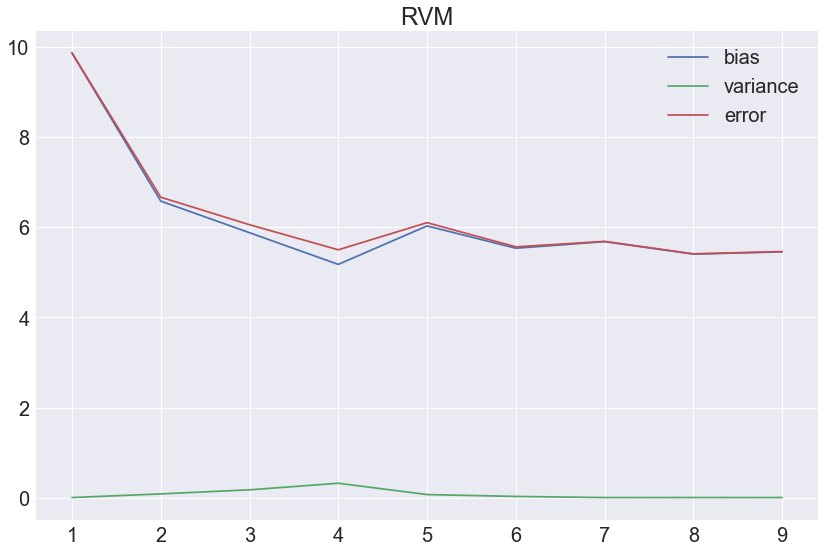

In [239]:
plt.figure(figsize = (14, 9))

plt.plot(degrees, bias, label='bias')
plt.plot(degrees, variance, label='variance')
plt.plot(degrees, error, label='error')

plt.legend()
plt.title("RVM")
plt.show()

In [279]:
pf = PolynomialFeatures(degree=3, include_bias=False)
X_train_pf = pf.fit_transform(X_train)
rvm = RVR(kernel='linear')
rvm.fit(X_train_pf, Y_train)
Y_pred, Y_pred_std = rvm.predict_dist(pf.transform(X_test))

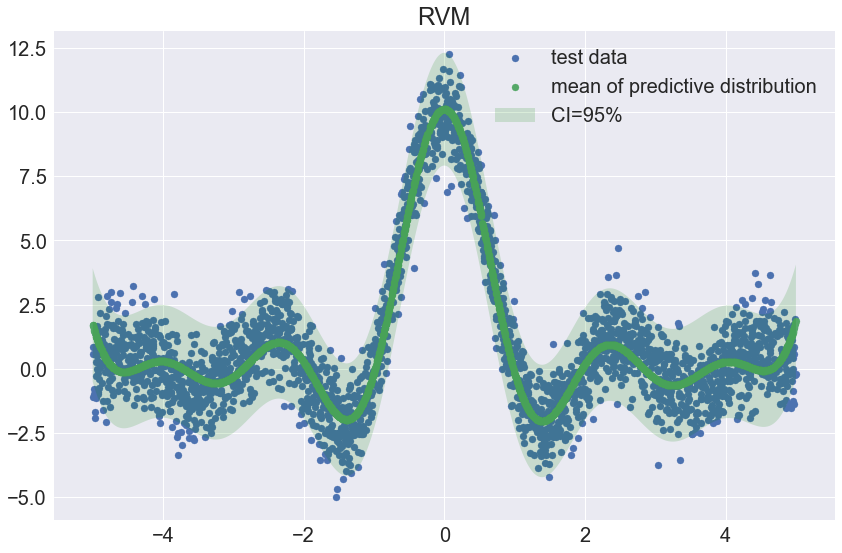

In [280]:
plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM")
plt.show()

### Bias-Variance от степени ядра

In [246]:
bias = []
variance = []
error = []
degrees = np.arange(1, 10)
resamples = 10

for degree in tqdm(degrees):
    
    Y_preds = []
    for _ in range(resamples):
        X_train_resample, Y_train_resample = resample(X_train, Y_train)
        rvm = RVR(kernel='poly', degree=degree)
        rvm.fit(X_train_resample, Y_train_resample)
        Y_pred = rvm.predict(X_test)
        Y_preds.append(Y_pred)
        
    Y_preds = np.array(Y_preds)
    bias.append(
        ((Y_preds.mean(axis=0) - Y_test)**2).mean()
    )
    variance.append(
        ((Y_preds - Y_preds.mean(axis=0))**2).mean(axis=1).mean()
    )
    error.append(
        ((Y_preds - Y_test)**2).mean(axis=1).mean()
    )
bias = np.array(bias)
variance = np.array(variance)
error = np.array(error)

100%|██████████| 9/9 [02:25<00:00, 18.81s/it]


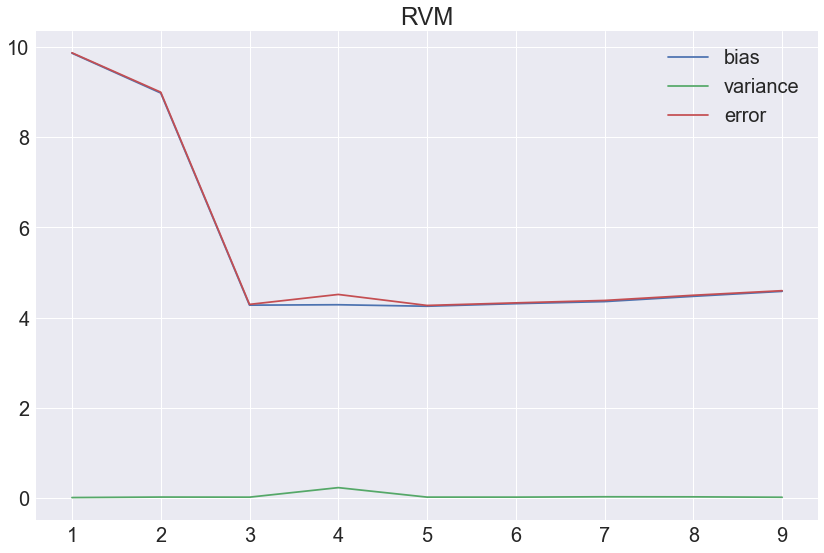

In [248]:
plt.figure(figsize = (14, 9))

plt.plot(degrees, bias, label='bias')
plt.plot(degrees, variance, label='variance')
plt.plot(degrees, error, label='error')

plt.legend()
plt.title("RVM")
plt.show()

In [260]:
rvm = RVR(kernel='linear', degree=3)
rvm.fit(X_train, Y_train)

RVR(coef0=1, copy_X=True, degree=3, fit_intercept=True, gamma=None,
  kernel='linear', kernel_params=None, n_iter=300, tol=0.001,
  verbose=False)

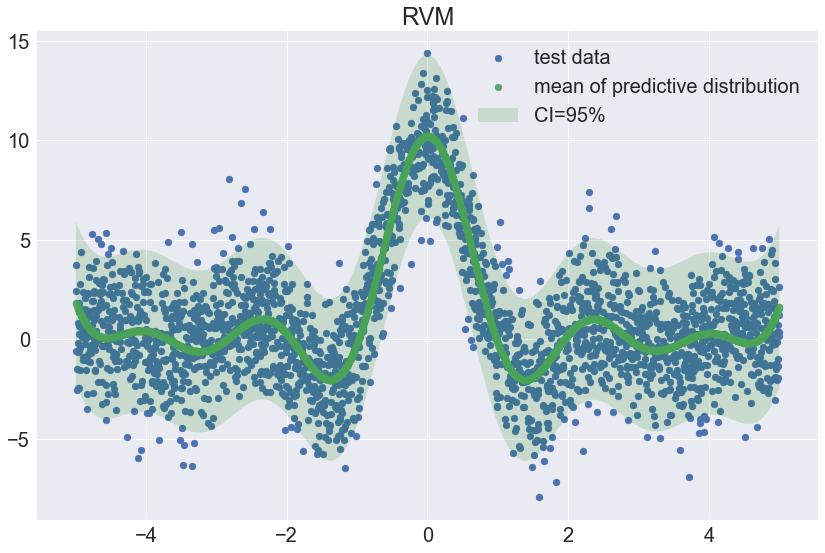

In [261]:
plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM")
plt.show()

### Bias-Variance от gamma в rbf

In [285]:
X_train.shape

(2500, 2)

In [286]:
Y_train.shape

(2500,)

In [287]:
bias = []
variance = []
error = []
gammas = np.logspace(-3, 1, 10)
resamples = 10

for gamma in tqdm(gammas):
    
    Y_preds = []
    for _ in range(resamples):
        X_train_resample, Y_train_resample = resample(X_train, Y_train)
        rvm = RVR(kernel='rbf', gamma=gamma)
        rvm.fit(X_train_resample, Y_train_resample)
        Y_pred = rvm.predict(X_test)
        Y_preds.append(Y_pred)
        
    Y_preds = np.array(Y_preds)
    bias.append(
        ((Y_preds.mean(axis=0) - Y_test)**2).mean()
    )
    variance.append(
        ((Y_preds - Y_preds.mean(axis=0))**2).mean(axis=1).mean()
    )
    error.append(
        ((Y_preds - Y_test)**2).mean(axis=1).mean()
    )
bias = np.array(bias)
variance = np.array(variance)
error = np.array(error)

100%|██████████| 10/10 [02:11<00:00, 17.18s/it]


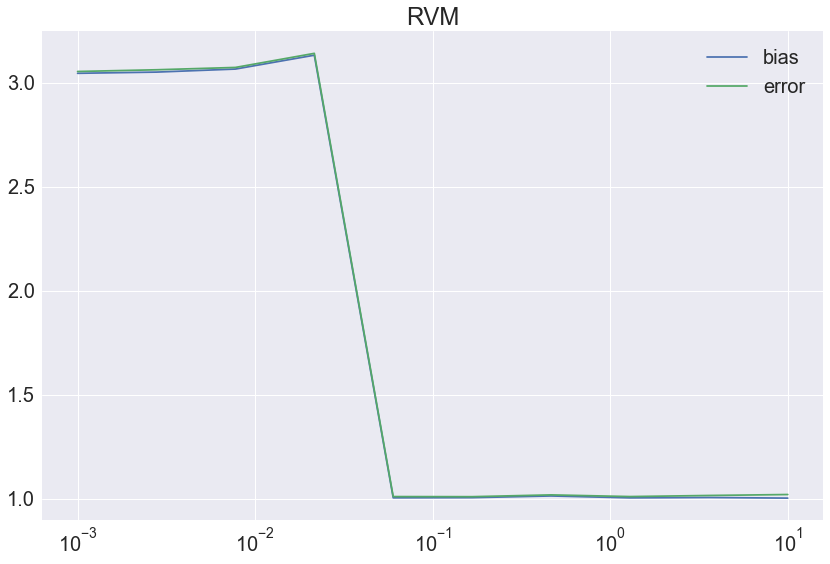

In [291]:
plt.figure(figsize = (14, 9))

plt.plot(gammas, bias, label='bias')
# plt.plot(gammas, variance, label='variance')
plt.plot(gammas, error, label='error')
plt.xscale('log')
plt.legend()
plt.title("RVM")
plt.show()

In [301]:
rvm = RVR(kernel='rbf', gamma=1)
rvm.fit(X_train, Y_train)

RVR(coef0=1, copy_X=True, degree=3, fit_intercept=True, gamma=1, kernel='rbf',
  kernel_params=None, n_iter=300, tol=0.001, verbose=False)

In [302]:
rvm.active_.sum()

19

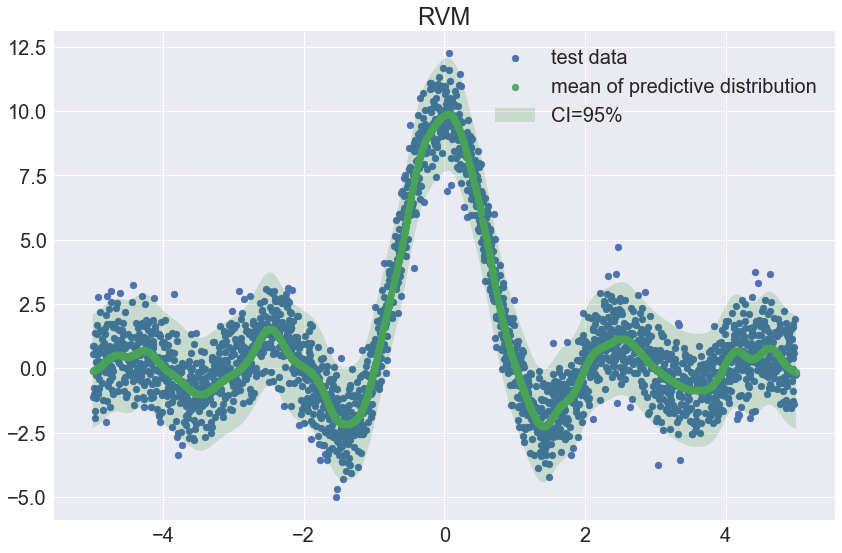

In [303]:
plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM")
plt.show()

### Bias-Variance от размера 

#### Вывод: мы увеличиваем сложность модели, а она почти не переобучается! OMG!!##@@#$@